In [68]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import h5py
from sklearn.model_selection import train_test_split

In [69]:
%%capture
import keras
import keras.backend as K
import tensorflow.keras as tk
from keras.layers import LeakyReLU

# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Извлечение данных

In [71]:
dataset_file = h5py.File("/kaggle/input/radioml2018/GOLD_XYZ_OSC.0001_1024.hdf5","r")

In [72]:
base_modulation_clases = ['OOK',
 '4ASK',
 '8ASK',
 'BPSK',
 'QPSK',
 '8PSK',
 '16PSK',
 '32PSK',
 '16APSK',
 '32APSK',
 '64APSK',
 '128APSK',
 '16QAM',
 '32QAM',
 '64QAM',
 '128QAM',
 '256QAM',
 'AM-SSB-WC',
 'AM-SSB-SC',
 'AM-DSB-WC',
 'AM-DSB-SC',
 'FM',
 'GMSK',
 'OQPSK']

selected_modulation_classes = [
#                                '8ASK', 
                               '4ASK', 
                               'BPSK', 
                               'QPSK', 
                               '16PSK', 
                               '16QAM', 
#                                '64QAM', 
#                                '256QAM',
                                'FM',
                                'AM-DSB-WC',
                                '32APSK'
                              ]

selected_classes_id = list()
for selected_class in selected_modulation_classes:
    for id, base_class in enumerate(base_modulation_clases):
        if selected_class == base_class:
            selected_classes_id.append(id)
selected_classes_id

[1, 3, 4, 6, 12, 21, 19, 9]

In [73]:
N_SNR = 4 # from 30 SNR to 22 SNR

X_data = list()
y_data = list()

for id in selected_classes_id:
    if len(X_data) != 0:
        X_data = np.concatenate([X_data, dataset_file['X'][(106496*(id+1) - 4096*N_SNR):106496*(id+1)]]) #Это только 1 модуляция, нужно шагом в 106496 выбрать другие
        y_data = np.concatenate([y_data, dataset_file['Y'][(106496*(id+1) - 4096*N_SNR):106496*(id+1)]])
    else:
        X_data = (dataset_file['X'][(106496*(id+1) - 4096*N_SNR):106496*(id+1)]) #Это только 1 модуляция, нужно шагом в 106496 выбрать другие
        y_data = (dataset_file['Y'][(106496*(id+1) - 4096*N_SNR):106496*(id+1)])

In [74]:
# Нужно решейпнуть входную последовательность к виду [N, 32,32,2]
X_data = X_data.reshape(len(X_data), 32, 32, 2)
X_data.shape

(131072, 32, 32, 2)

In [75]:
y_data_df = pd.DataFrame(y_data)
for column in y_data_df.columns:
    if sum(y_data_df[column]) == 0:
        y_data_df = y_data_df.drop(columns = [column])
y_data_df.columns = selected_modulation_classes
y_data_df

,4ASK,BPSK,QPSK,16PSK,16QAM,FM,AM-DSB-WC,32APSK
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
131067,0,0,0,0,1,0,0,0
131068,0,0,0,0,1,0,0,0
131069,0,0,0,0,1,0,0,0
131070,0,0,0,0,1,0,0,0


# Подготовка данных и модели

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data_df, test_size = 0.2)

## Оформляем модель

In [77]:
def create_model():
    learning_rate = 0.0001
    # learning_rate = 2e-4,

    i_input = keras.layers.Input(shape=(32,32,1))
    q_input = keras.layers.Input(shape=(32,32,1))

    #84% - 10 итераций
    # # Слои для квадратурной составляющей
    # cnn_q_1 = tk.layers.Conv2D(128, 5, activation = LeakyReLU(alpha = 0.1))(q_input)
    # pool_q_1 = tk.layers.MaxPool2D(pool_size = 3, strides = 2, padding = 'valid')(cnn_q_1)
    # cnn_q_2 = tk.layers.Conv2D(128, 5, activation = LeakyReLU(alpha = 0.1))(pool_q_1)
    # pool_q_2 = tk.layers.MaxPool2D(pool_size = 3, strides = 2, padding = 'valid')(cnn_q_2)
    # flatten_q = tk.layers.Flatten()(pool_q_2)

    # # Слои для синфазной составляющей
    # cnn_i_1 = tk.layers.Conv2D(128, 5, activation = LeakyReLU(alpha = 0.1))(i_input)
    # pool_i_1 = tk.layers.MaxPool2D(pool_size = 3, strides = 2, padding = 'valid')(cnn_i_1)
    # cnn_i_2 = tk.layers.Conv2D(128, 5, activation = LeakyReLU(alpha = 0.1))(pool_i_1)
    # pool_i_2 = tk.layers.MaxPool2D(pool_size = 3, strides = 2, padding = 'valid')(cnn_i_2)
    # flatten_i = tk.layers.Flatten()(pool_i_2)

    #90% - 15 итераций - другие классы
    # Слои для квадратурной составляющей
    cnn_q_1 = tk.layers.Conv2D(64, 3, activation = LeakyReLU(alpha = 0.1))(q_input)
    cnn_q_1_2 = tk.layers.Conv2D(64, 3, activation = LeakyReLU(alpha = 0.1))(cnn_q_1)
    pool_q_1 = tk.layers.MaxPool2D(pool_size = 3, strides = 2, padding = 'valid')(cnn_q_1)
    cnn_q_2 = tk.layers.Conv2D(128, 3, activation = LeakyReLU(alpha = 0.1))(pool_q_1)
    cnn_q_2_2 = tk.layers.Conv2D(128, 3, activation = LeakyReLU(alpha = 0.1))(cnn_q_2)
    pool_q_2 = tk.layers.MaxPool2D(pool_size = 3, strides = 2, padding = 'valid')(cnn_q_2_2)
    flatten_q = tk.layers.Flatten()(pool_q_2)

    # Слои для синфазной составляющей
    cnn_i_1 = tk.layers.Conv2D(64, 3, activation = LeakyReLU(alpha = 0.1))(i_input)
    cnn_i_1_2 = tk.layers.Conv2D(64, 3, activation = LeakyReLU(alpha = 0.1))(cnn_i_1)
    pool_i_1 = tk.layers.MaxPool2D(pool_size = 3, strides = 2, padding = 'valid')(cnn_i_1_2)
    cnn_i_2 = tk.layers.Conv2D(128, 3, activation = LeakyReLU(alpha = 0.1))(pool_i_1)
    cnn_i_2_2 = tk.layers.Conv2D(128, 3, activation = LeakyReLU(alpha = 0.1))(cnn_i_2)
    pool_i_2 = tk.layers.MaxPool2D(pool_size = 3, strides = 2, padding = 'valid')(cnn_i_2_2)
    flatten_i = tk.layers.Flatten()(pool_i_2)

    concat = keras.layers.concatenate([flatten_q, flatten_i])
    dense1 = keras.layers.Dense(1024, activation = LeakyReLU(alpha = 0.1))(concat)
    dense2 = keras.layers.Dense(1024, activation = LeakyReLU(alpha = 0.1))(dense1)
    dense3 = keras.layers.Dense(1024, activation = LeakyReLU(alpha = 0.1))(dense2)
    dense4 = keras.layers.Dense(256, activation = LeakyReLU(alpha = 0.1))(dense3)
    dense5 = keras.layers.Dense(32, activation = LeakyReLU(alpha = 0.1))(dense4) #Сомнительный слой, возможно стоит убрать
    outputs = keras.layers.Dense(len(selected_classes_id), activation='softmax')(dense5)

    model = keras.Model(inputs=[i_input, q_input], outputs=outputs)
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=tk.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    # model.summary()
    return model

model = create_model()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [78]:
batch_size = 64
epochs = 15

path_checkpoint = "model_checkpoint.weights.h5"
es_callback = tk.callbacks.EarlyStopping(monitor="accuracy", min_delta=0, patience=10)

modelckpt_callback = tk.callbacks.ModelCheckpoint(
    monitor="accuracy",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(

    x = [X_train[:,:,:,0], X_train[:,:,:,1]],
    y = y_train,

    batch_size = batch_size,
    epochs=epochs,
    validation_data=([X_test[:,:,:,0], X_test[:,:,:,1]], y_test),
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/15
  10/1639 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.1248 - loss: 2.0607

W0000 00:00:1717884271.881499    1043 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1639/1639 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5965 - loss: 0.8799

W0000 00:00:1717884297.364805    1043 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717884298.539773    1044 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: accuracy improved from -inf to 0.67048, saving model to model_checkpoint.weights.h5


W0000 00:00:1717884300.788206    1045 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1639/1639 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.5965 - loss: 0.8798 - val_accuracy: 0.7696 - val_loss: 0.4992
Epoch 2/15
1636/1639 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7630 - loss: 0.5204
Epoch 2: accuracy improved from 0.67048 to 0.76900, saving model to model_checkpoint.weights.h5
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.7630 - loss: 0.5203 - val_accuracy: 0.7756 - val_loss: 0.4758
Epoch 3/15
1637/1639 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7808 - loss: 0.4781
Epoch 3: accuracy improved from 0.76900 to 0.78384, saving model to model_checkpoint.weights.h5
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.7808 - loss: 0.4781 - val_accuracy: 0.7930 - val_loss: 0.4553
Epoch 4/15
1635/1639 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7966 - loss: 0.4436
Epoch 4: accuracy improved from 0.78384 to 0.80419, saving model to model_checkpoint.weights.h5
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.7967 - loss: 0.4436 - v

# Валидация

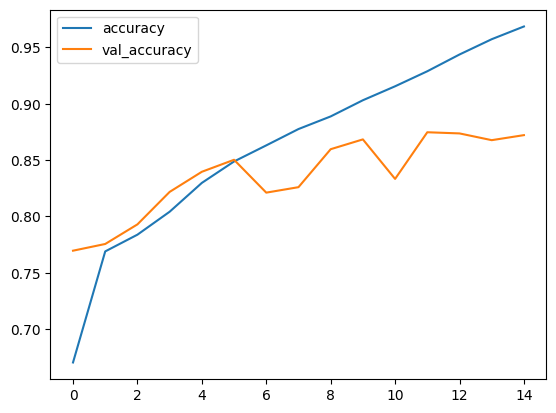

In [86]:
plt.plot(np.c_[history.history['accuracy'],history.history['val_accuracy']])
plt.legend(['accuracy', 'val_accuracy'])

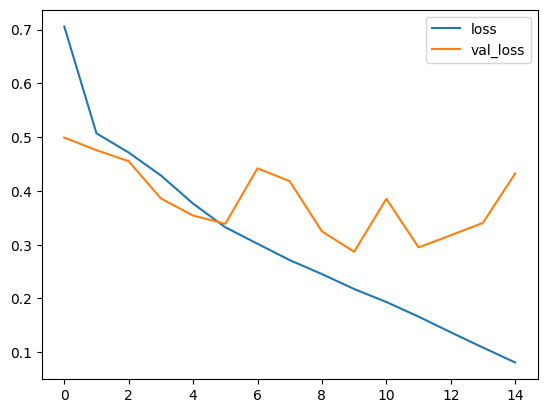

In [85]:
plt.plot(np.c_[history.history['loss'],history.history['val_loss']])
plt.legend(['loss', 'val_loss'])

## Матрица ошибок

In [87]:
model_predictions = model.predict([X_test[:,:,:,0], X_test[:,:,:,1]])
model_predictions

820/820 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[3.1597395e-07, 9.9965325e-07, 3.1262229e-07, ..., 4.2751465e-02,
        9.6401136e-09, 1.6678167e-09],
       [4.3209807e-14, 1.0000000e+00, 1.1794929e-08, ..., 6.9209902e-15,
        7.4591323e-12, 4.0400905e-11],
       [2.7581663e-08, 2.9852369e-08, 6.2353472e-08, ..., 7.7591246e-01,
        9.2940866e-10, 4.9612602e-11],
       ...,
       [9.9999988e-01, 1.3810928e-13, 3.7254619e-27, ..., 6.8264897e-15,
        6.5543972e-08, 1.0820347e-20],
       [1.7783173e-09, 9.5690837e-11, 2.7398281e-25, ..., 1.5758054e-20,
        1.0000000e+00, 5.6903299e-10],
       [4.5811966e-17, 1.0000000e+00, 9.5001368e-12, ..., 2.0794584e-18,
        5.0449113e-14, 2.0115222e-13]], dtype=float32)

In [88]:
def convert_to_matrix(logit_list):
    logit_list = list(logit_list)
    return logit_list.index(max(logit_list))

cm = confusion_matrix(
    y_true = list(map(convert_to_matrix , y_test.values)),
    y_pred = list(map(convert_to_matrix , model_predictions)),
)

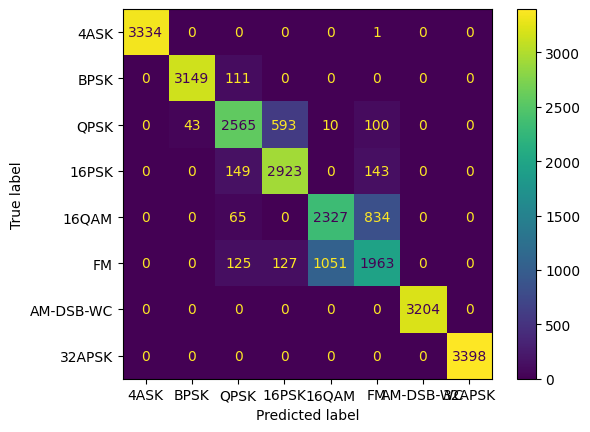

In [89]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=selected_modulation_classes)
disp.plot()
plt.show()

In [ ]:
# Сохраняем веса
model.save_weights('/kaggle/working/CNN_model.weights.h5')

In [90]:
# Создаем шаблон модели
loaded_model = create_model()

# Загружаем веса модели
loaded_model.load_weights('/kaggle/working/CNN_model.weights.h5')

# Тестируем загруженную модель на тест сете
loss, acc = model.evaluate([X_test[:,:,:,0], X_test[:,:,:,1]], y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


820/820 - 2s - 3ms/step - accuracy: 0.8721 - loss: 0.4326
Restored model, accuracy: 87.21%
